# MODELING AND EVALUATION

## Objectives

*  Fit and evaluate a classification model to predict if a prospect will churn or not.

## Inputs

jupyter_notebooks/outputs/engineered/X_test.pkl
jupyter_notebooks/outputs/engineered/Y_test.pkl
jupyter_notebooks/outputs/engineered/X_train.pkl
jupyter_notebooks/outputs/engineered/Y_test.pkl

## Outputs

* Trained classification model with feature importance analysis
* Data preprocessing and feature engineering pipeline
* Prediction function for deployment
* Model evaluation metrics and validation results

---

# Change working directory

Change the working directory from its current folder to its parent folder


In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Film_Hit_prediction/jupyter_notebooks'

Make the parent of the current directory the new current directory.


In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Film_Hit_prediction'

---

# Load Data 

Load Data

In [4]:
import pandas as pd
import pickle

# Load the splits for modeling
X_train = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_train.pkl')
X_test = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_test.pkl')
y_train = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_train.pkl')
y_test = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_test.pkl')


print("Dataset shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Dataset shapes:
X_train shape: (3284, 270)
y_train shape: (3284,)
X_test shape: (813, 270)
y_test shape: (813,)


---

## ML Pipelines

Cleaning pipeline

In [5]:
import joblib
import pickle
import pandas as pd
import numpy as np


cleaning_pipeline = {}
# Load encoders and filters 
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/cleaned/encoders_and_filters.pkl', 'rb') as f:
    encoders_and_filters = pickle.load(f)

# Extract encoders and filters
mlb_crew = encoders_and_filters['mlb_crew']
crew_min_appearances = encoders_and_filters['crew_min_appearances']
crew_frequent_columns = encoders_and_filters['crew_frequent_columns']
important_crew_positions = encoders_and_filters['important_crew_positions']

mlb_cast = encoders_and_filters['mlb_cast']
cast_min_appearances = encoders_and_filters['cast_min_appearances']
frequent_cast_members = encoders_and_filters['frequent_cast_members']

mlb_countries = encoders_and_filters['mlb_countries']
country_min_appearances = encoders_and_filters['country_min_appearances']
frequent_countries = encoders_and_filters['frequent_countries']

mlb_companies = encoders_and_filters['mlb_companies']
company_min_appearances = encoders_and_filters['company_min_appearances']
frequent_companies = encoders_and_filters['frequent_companies']

language_encoder = encoders_and_filters['language_encoder']
genre_columns = encoders_and_filters['genre_columns']

def clean_data(X_train, X_test=None):
    
    def transform_dataset(X):
        X = X.copy()
        
        
        # Filter crew by minimum appearances
        def filter_crew(crew_list):
            return [person for person in crew_list if person in crew_frequent_columns]

        # Filter cast by minimum appearances
        def filter_cast(cast_list):
            return [actor for actor in cast_list if actor in frequent_cast_members]

        # Filter countries by minimum appearances
        def filter_countries(countries):
            return [country for country in countries if country in frequent_countries]

        # Filter companies by minimum appearances
        def filter_companies(companies):
            return [company for company in companies if company in frequent_companies]

        # Apply filters
        X['crew'] = X['crew'].apply(filter_crew)
        X['cast'] = X['cast'].apply(filter_cast)
        X['production_countries'] = X['production_countries'].apply(filter_countries)
        X['production_companies'] = X['production_companies'].apply(filter_companies)

        # Crew
        crew_cols = [f'crew_{i}' for i in crew_frequent_columns]
        X[crew_cols] = mlb_crew.transform(X['crew'])
        
        # Cast
        cast_cols = [f'cast_{i}' for i in frequent_cast_members]
        X[cast_cols] = mlb_cast.transform(X['cast'])
        
        # Countries
        country_cols = [f'country_{i}' for i in frequent_countries]
        X[country_cols] = mlb_countries.transform(X['production_countries'])
        
        # Companies
        company_cols = [f'company_{i}' for i in frequent_companies]
        X[company_cols] = mlb_companies.transform(X['production_companies'])
        
        # Language encoding
        X['language_encoded'] = language_encoder.transform(X['original_language'])
        
        # Budget filter
        X = X[X['budget'] > 0]

        # Drop original columns after encoding
        columns_to_drop = ['crew', 'cast', 'production_countries', 
                        'production_companies', 'original_language']
        X = X.drop(columns=columns_to_drop, errors='ignore')
        
        return X
    
    # Transform training data
        X_train_clean = transform_dataset(X_train)
        print(f"Training shape after cleaning: {X_train_clean.shape}")
        print("Applied filters:")
        print(f"- Crew min appearances: {crew_min_appearances}")
        print(f"- Cast min appearances: {cast_min_appearances}")
        print(f"- Country min appearances: {country_min_appearances}")
        print(f"- Company min appearances: {company_min_appearances}")
    
    # Transform test data 
        if X_test is not None:
            X_test_clean = transform_dataset(X_test)
            print(f"\nTest shape after cleaning: {X_test_clean.shape}")
        return X_train_clean, X_test_clean
    
    return X_train_clean

# pipeline dictionary 
cleaning_pipeline = {
    'clean_data': clean_data,
    'encoders_and_filters': encoders_and_filters
}

# Save 
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/cleaned/cleaning_pipeline.pkl', 'wb') as f:
    pickle.dump(cleaning_pipeline, f, protocol=3)

print("Cleaning pipeline saved successfully!")

Cleaning pipeline saved successfully!


Inside the pickled files (remove when run the notebook for the last time)

In [6]:
import pickle
import pandas as pd
import numpy as np

def inspect_pickle(file_path, name=""):
    print(f"\n{'='*50}")
    print(f"Inspecting: {name}")
    print(f"{'='*50}")
    
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    print(f"Type: {type(data)}")
    
    if isinstance(data, pd.DataFrame):
        print("\nDataFrame Info:")
        print(f"Shape: {data.shape}")
        print("\nColumns:")
        for col in data.columns:
            print(f"- {col} ({data[col].dtype})")
        print("\nFirst few rows:")
        print(data.head())
        
    elif isinstance(data, pd.Series):
        print("\nSeries Info:")
        print(f"Length: {len(data)}")
        print(f"dtype: {data.dtype}")
        print("\nFirst few values:")
        print(data.head())
        
    elif isinstance(data, (list, tuple)):
        print(f"\nLength: {len(data)}")
        print("First few elements:")
        print(data[:5])
        
    elif hasattr(data, 'get_params'):  
        print("\nParameters:")
        print(data.get_params())
        
    else:
        print("\nContent preview:")
        print(data)

base_path = '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered'

files_to_inspect = {
    'Feature Scaler': 'feature_scaler.pkl',
    'Transformation Data': 'full_transformation_data.pkl',
    'Top Revenue Actors': 'top_revenue_actors.pkl',
    'Top Revenue Directors': 'top_revenue_directors.pkl',
    'Top Revenue Producers': 'top_revenue_producers.pkl',
    'Top Revenue Writers': 'top_revenue_writers.pkl'
}

for name, file in files_to_inspect.items():
    file_path = f"{base_path}/{file}"
    inspect_pickle(file_path, name)


Inspecting: Feature Scaler
Type: <class 'sklearn.preprocessing._data.StandardScaler'>

Parameters:
{'copy': True, 'with_mean': True, 'with_std': True}

Inspecting: Transformation Data
Type: <class 'dict'>

Content preview:
{'feature_scaler': StandardScaler(), 'encoders_and_filters': {'mlb_crew': MultiLabelBinarizer(), 'crew_min_appearances': 10, 'crew_frequent_columns': ['crew_Director_aaron seltzer', 'crew_Director_adam mckay', 'crew_Director_adam shankman', 'crew_Director_alejandro gonzález iñárritu', 'crew_Director_alex proyas', 'crew_Director_alexander payne', 'crew_Director_alfonso cuarón', 'crew_Director_alfred hitchcock', 'crew_Director_andrew adamson', 'crew_Director_andrew niccol', 'crew_Director_andrzej bartkowiak', 'crew_Director_andy fickman', 'crew_Director_andy tennant', 'crew_Director_ang lee', 'crew_Director_anne fletcher', 'crew_Director_antoine fuqua', 'crew_Director_atom egoyan', 'crew_Director_barry levinson', 'crew_Director_barry sonnenfeld', 'crew_Director_ben st

Feature engineering pipeline

In [7]:
import pandas as pd
import numpy as np
from typing import Dict, List, Any
import pickle

class MovieFeatureEngineeringPipeline:
    def __init__(self, 
                feature_scaler: Any,
                transform_data: Dict[str, Any],
                actor_data: Dict[str, Dict],
                director_data: Dict[str, Dict],
                producer_data: Dict[str, Dict],
                writer_data: Dict[str, Dict]):
        
        self.feature_scaler = feature_scaler
        self.transform_data = transform_data
        self.actor_data = actor_data
        self.director_data = director_data
        self.producer_data = producer_data
        self.writer_data = writer_data
        
    def add_actor_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        # metrics for each actor
        metrics = self.actor_data['metrics']
        
        # New feature columns
        df['cast_avg_revenue'] = 0.0
        df['cast_revenue_consistency'] = 0.0
        df['cast_hit_rate'] = 0.0
        df['cast_popularity'] = 0.0
        df['cast_pop_consistency'] = 0.0
        df['cast_rev_pop_correlation'] = 0.0
        df['cast_experience'] = 0.0
        df['top_cast_composite_score'] = 0.0
        
        # Actor metrics
        cast_columns = [col for col in df.columns if col.startswith('cast_') and col in self.actor_data['columns']]
        
        for idx, row in df.iterrows():
            present_actors = [col.replace('cast_', '') for col in cast_columns if row[col] == 1]
            
            if present_actors:
                actor_metrics = [metrics[actor] for actor in present_actors if actor in metrics]
                if actor_metrics:
                    df.loc[idx, 'cast_avg_revenue'] = np.mean([m['avg_revenue'] for m in actor_metrics])
                    df.loc[idx, 'cast_revenue_consistency'] = np.mean([m['revenue_consistency'] for m in actor_metrics])
                    df.loc[idx, 'cast_hit_rate'] = np.mean([m['hit_rate'] for m in actor_metrics])
                    df.loc[idx, 'cast_popularity'] = np.mean([m['avg_popularity'] for m in actor_metrics])
                    df.loc[idx, 'cast_pop_consistency'] = np.mean([m['popularity_consistency'] for m in actor_metrics])
                    df.loc[idx, 'cast_rev_pop_correlation'] = np.mean([m['revenue_popularity_correlation'] for m in actor_metrics])
                    df.loc[idx, 'cast_experience'] = np.mean([m['movies_count'] for m in actor_metrics])
                    df.loc[idx, 'top_cast_composite_score'] = np.mean([m['composite_score'] for m in actor_metrics])
        
        return df

    def add_director_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        metrics = self.director_data['metrics']
        
        df['director_avg_revenue'] = 0.0
        df['director_hit_rate'] = 0.0
        df['director_experience'] = 0.0
        df['director_composite_score'] = 0.0
        
        director_columns = [col for col in df.columns if col.startswith('crew_Director_') and col in self.director_data['columns']]
        
        for idx, row in df.iterrows():
            present_directors = [col.replace('crew_Director_', '') for col in director_columns if row[col] == 1]
            
            if present_directors:
                director_metrics = [metrics[director] for director in present_directors if director in metrics]
                if director_metrics:
                    df.loc[idx, 'director_avg_revenue'] = np.mean([m['avg_revenue'] for m in director_metrics])
                    df.loc[idx, 'director_hit_rate'] = np.mean([m['hit_rate'] for m in director_metrics])
                    df.loc[idx, 'director_experience'] = np.mean([m['movies_count'] for m in director_metrics])
                    df.loc[idx, 'director_composite_score'] = np.mean([m['composite_score'] for m in director_metrics])
        
        return df

    def add_producer_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        metrics = self.producer_data['metrics']
        
        df['producer_avg_revenue'] = 0.0
        df['producer_hit_rate'] = 0.0
        df['producer_experience'] = 0.0
        df['producer_composite_score'] = 0.0
        
        producer_columns = [col for col in df.columns if col.startswith('crew_Producer_') and col in self.producer_data['columns']]
        
        for idx, row in df.iterrows():
            present_producers = [col.replace('crew_Producer_', '') for col in producer_columns if row[col] == 1]
            
            if present_producers:
                producer_metrics = [metrics[producer] for producer in present_producers if producer in metrics]
                if producer_metrics:
                    df.loc[idx, 'producer_avg_revenue'] = np.mean([m['avg_revenue'] for m in producer_metrics])
                    df.loc[idx, 'producer_hit_rate'] = np.mean([m['hit_rate'] for m in producer_metrics])
                    df.loc[idx, 'producer_experience'] = np.mean([m['movies_count'] for m in producer_metrics])
                    df.loc[idx, 'producer_composite_score'] = np.mean([m['composite_score'] for m in producer_metrics])
        
        return df

    def add_writer_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        metrics = self.writer_data['metrics']
        
        df['writer_avg_revenue'] = 0.0
        df['writer_hit_rate'] = 0.0
        df['writer_experience'] = 0.0
        df['writer_composite_score'] = 0.0
        
        writer_columns = [col for col in df.columns if col.startswith('crew_Writer_') and col in self.writer_data['columns']]
        
        for idx, row in df.iterrows():
            present_writers = [col.replace('crew_Writer_', '') for col in writer_columns if row[col] == 1]
            
            if present_writers:
                writer_metrics = [metrics[writer] for writer in present_writers if writer in metrics]
                if writer_metrics:
                    df.loc[idx, 'writer_avg_revenue'] = np.mean([m['avg_revenue'] for m in writer_metrics])
                    df.loc[idx, 'writer_hit_rate'] = np.mean([m['hit_rate'] for m in writer_metrics])
                    df.loc[idx, 'writer_experience'] = np.mean([m['movies_count'] for m in writer_metrics])
                    df.loc[idx, 'writer_composite_score'] = np.mean([m['composite_score'] for m in writer_metrics])
        
        return df

    def add_combined_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        # Crew metrics
        df['total_crew_experience'] = (
            df['director_experience'] + 
            df['producer_experience'] + 
            df['writer_experience']
        )
        
        # Success metrics
        df['avg_crew_hit_rate'] = (
            df[['director_hit_rate', 'producer_hit_rate', 'writer_hit_rate']].mean(axis=1)
        )
        
        # Composite scores
        df['crew_composite_score'] = (
            df[['director_composite_score', 'producer_composite_score', 
                'writer_composite_score']].mean(axis=1)
        )
        
        # Project score
        df['project_score'] = (
            (df['crew_composite_score'] * 0.6) + 
            (df['top_cast_composite_score'] * 0.4)
        )
        
        return df

    def add_budget_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add budget-related features"""
        # Budget per minute 
        df['budget_per_minute'] = df['budget'] / df['runtime']
        
        # Budget compared to crew average
        df['budget_to_director_avg'] = df['budget'] / df['director_avg_revenue']
        df['budget_to_producer_avg'] = df['budget'] / df['producer_avg_revenue']
        
        # NaNs
        budget_cols = ['budget_per_minute', 'budget_to_director_avg', 'budget_to_producer_avg']
        df[budget_cols] = df[budget_cols].replace([np.inf, -np.inf], np.nan)
        df[budget_cols] = df[budget_cols].fillna(0)
        
        return df

    def scale_features(self, df: pd.DataFrame) -> pd.DataFrame:
        numeric_features = [
            'cast_avg_revenue', 'cast_revenue_consistency', 'cast_hit_rate',
            'cast_popularity', 'cast_pop_consistency', 'cast_rev_pop_correlation',
            'cast_experience', 'top_cast_composite_score',
            'director_avg_revenue', 'director_hit_rate', 'director_experience',
            'director_composite_score', 'producer_avg_revenue', 'producer_hit_rate',
            'producer_experience', 'producer_composite_score', 'writer_avg_revenue',
            'writer_hit_rate', 'writer_experience', 'writer_composite_score',
            'total_crew_experience', 'avg_crew_hit_rate', 'crew_composite_score',
            'project_score', 'budget_per_minute', 'budget_to_director_avg',
            'budget_to_producer_avg'
        ]
        
        df[numeric_features] = self.feature_scaler.transform(df[numeric_features])
        return df

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:

        # copy 
        df = df.copy()
        
        # metrics 
        df = self.add_actor_metrics(df)
        df = self.add_director_metrics(df)
        df = self.add_producer_metrics(df)
        df = self.add_writer_metrics(df)
        
        # Combined and derived features
        df = self.add_combined_metrics(df)
        df = self.add_budget_features(df)
        
        # Scale features
        df = self.scale_features(df)
        
        return df

def load_pipeline(
    feature_scaler_path: str,
    transform_data_path: str,
    actor_data_path: str,
    director_data_path: str,
    producer_data_path: str,
    writer_data_path: str
) -> MovieFeatureEngineeringPipeline:

    import pickle
    
    with open(feature_scaler_path, 'rb') as f:
        feature_scaler = pickle.load(f)
    
    with open(transform_data_path, 'rb') as f:
        transform_data = pickle.load(f)
        
    with open(actor_data_path, 'rb') as f:
        actor_data = pickle.load(f)
        
    with open(director_data_path, 'rb') as f:
        director_data = pickle.load(f)
        
    with open(producer_data_path, 'rb') as f:
        producer_data = pickle.load(f)
        
    with open(writer_data_path, 'rb') as f:
        writer_data = pickle.load(f)
    
    return MovieFeatureEngineeringPipeline(
        feature_scaler=feature_scaler,
        transform_data=transform_data,
        actor_data=actor_data,
        director_data=director_data,
        producer_data=producer_data,
        writer_data=writer_data
    )

def create_and_save_pipeline(base_path: str = '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/') -> None:
   
    # Paths
    paths = {
        'feature_scaler': f"{base_path}engineered/feature_scaler.pkl",
        'transform_data': f"{base_path}engineered/full_transformation_data.pkl",
        'actor_data': f"{base_path}engineered/top_revenue_actors.pkl",
        'director_data': f"{base_path}engineered/top_revenue_directors.pkl",
        'producer_data': f"{base_path}engineered/top_revenue_producers.pkl",
        'writer_data': f"{base_path}engineered/top_revenue_writers.pkl"
    }
    
    pipeline = load_pipeline(
        feature_scaler_path=paths['feature_scaler'],
        transform_data_path=paths['transform_data'],
        actor_data_path=paths['actor_data'],
        director_data_path=paths['director_data'],
        producer_data_path=paths['producer_data'],
        writer_data_path=paths['writer_data']
    )
    
    # Save 
    pipeline_path = f"{base_path}models/movie_feature_engineering_pipeline.pkl"
    with open(pipeline_path, 'wb') as f:
        pickle.dump(pipeline, f, protocol=3)
    
    print(f"Pipeline successfully saved to {pipeline_path}")

if __name__ == "__main__":
    create_and_save_pipeline()

Pipeline successfully saved to /workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/movie_feature_engineering_pipeline.pkl


---

### Model Development and Evaluation

Hyperparameter Optimisation

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler

models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'solver': ['auto', 'svd', 'cholesky']
        }
    },
    'Lasso': {
        'model': Lasso(random_state=42),  
        'params': {
            'alpha': [0.1 ],  
            'max_iter': [500],
            'tol': [0.1], 
            'selection': ['cyclic']
        }   
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'n_jobs': [-1]
        }
    },
}

Model set up and training

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.model_selection import cross_val_score

results = {}
best_models = {}

for name, model_info in models.items():
    print(f"\n{'='*50}")
    print(f"\nTraining {name}...")

    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs= 1 ,
        verbose=2
    )
    
    grid_search.fit(X_train, y_train.ravel())
    best_models[name] = grid_search.best_estimator_



Training Linear Regression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s


Training Ridge...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ............................alpha=0.01, solver=auto; total time=   0.5s
[CV] END ............................alpha=0.01, solver=auto; total time=   0.3s
[CV] END ............................alpha=0.01, solver=auto; total time=   0.4s
[CV] END .............................alpha=0.01, solver=svd; total time=   1.7s
[CV] END .............................alpha=0.01, solver=svd; total time=   1.5s
[CV] END .............................alpha=0.01, solver=svd; total time=   2.6s
[CV] END ........................alpha=0.01, solver=cholesky; total time=   0.5s
[CV] END .........

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.224676993513265e+18, tolerance: 5.675845745774622e+18
  model = cd_fast.enet_coordinate_descent(


[CV] END .alpha=0.1, max_iter=500, selection=cyclic, tol=0.1; total time=   7.0s


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.150166574169425e+18, tolerance: 6.982214786800407e+18
  model = cd_fast.enet_coordinate_descent(


[CV] END .alpha=0.1, max_iter=500, selection=cyclic, tol=0.1; total time=   6.9s


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.850293497845535e+18, tolerance: 6.58060058427811e+18
  model = cd_fast.enet_coordinate_descent(


[CV] END .alpha=0.1, max_iter=500, selection=cyclic, tol=0.1; total time=   6.6s


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2054651720417278e+19, tolerance: 9.619486165716589e+18
  model = cd_fast.enet_coordinate_descent(




Training Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   1.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   1.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   1.8s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.9s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.8s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200, n_jobs=-1; total time

Evaluate Performance

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.model_selection import cross_val_score

for name, model in best_models.items():
    print(f"\nTraining {name}...")

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2,
        'Best Parameters': grid_search.best_params_
    }
    
    print(f"\nResults for {name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    print(f"Best Parameters: {grid_search.best_params_}")


Training Linear Regression...

Results for Linear Regression:
RMSE: 98933804.20
R2 Score: 0.66
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1}

Training Ridge...

Results for Ridge:
RMSE: 98681577.29
R2 Score: 0.66
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1}

Training Lasso...

Results for Lasso:
RMSE: 99063526.74
R2 Score: 0.66
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1}

Training Random Forest...

Results for Random Forest:
RMSE: 79916320.73
R2 Score: 0.78
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1}


Save best performing model

In [11]:
import os
import joblib

best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = best_models[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"Best model RMSE: {results[best_model_name]['RMSE']:.2f}")

save_dir = '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models'
os.makedirs(save_dir, exist_ok=True)  

from datetime import datetime
current_date = datetime.now().strftime("%Y%m%d")
model_filename = f'film_revenue_model_{best_model_name}_{current_date}.joblib'
full_path = os.path.join(save_dir, model_filename)

joblib.dump(best_model, full_path, protocol=3)

print(f"\nBest model saved as: {model_filename}")
print("Best model saved successfully!")



Best performing model: Random Forest
Best model RMSE: 79916320.73

Best model saved as: film_revenue_model_Random Forest_20250125.joblib
Best model saved successfully!


---

## Assess feature importance

Loaded model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Top 10 Most Important Features:
                                    Feature  Importance
24                               popularity    0.343301
18                                   budget    0.331251
35                        budget_per_minute    0.084436
236                                 runtime    0.028993
116  crew_Producer_james cameron_pop_weight    0.026536
258             crew_Producer_james cameron    0.024198
93                                Adventure    0.010615
151                    other_producer_count    0.009677
245                       other_actor_count    0.008848
239                       cast_Frank Welker    0.005274


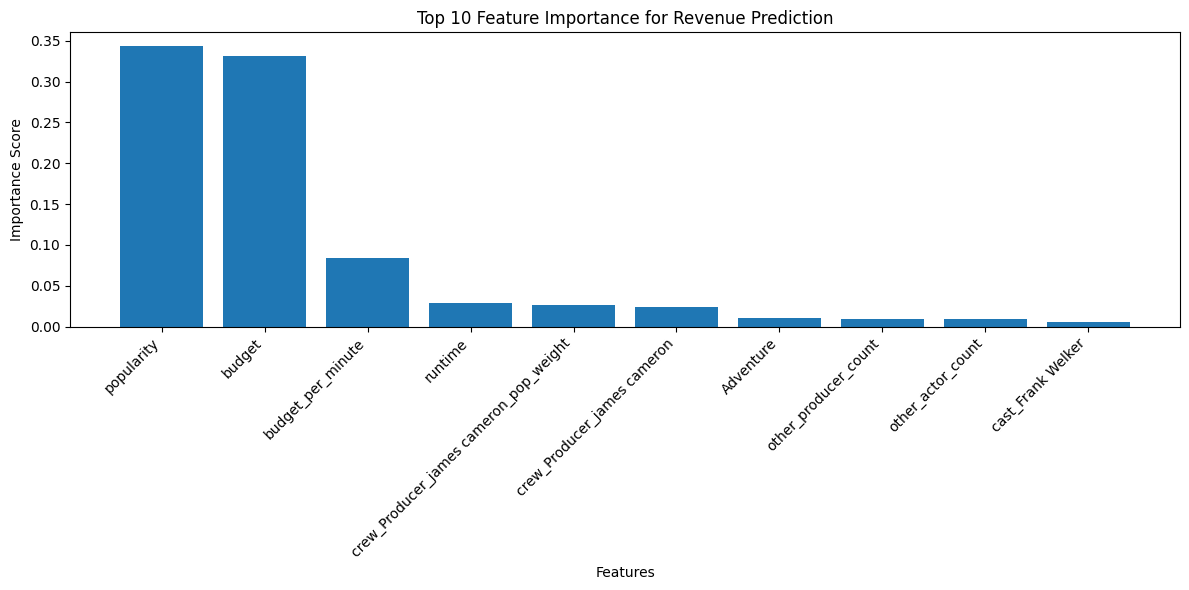

In [12]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

model_path = '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/film_revenue_model_Random Forest_20250125.joblib'
loaded_model = joblib.load(model_path)
print("Loaded model type:", type(loaded_model))

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': loaded_model.feature_importances_
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot 
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance for Revenue Prediction')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


---

# Prediction Model


Create a function to make predictions for new movies revenues and profit based on parameters:
-  budget, popularity, runtime, language, genres, cast, director, writer, producer, porduction company, production country
 Returns:
- Predicted revenue and profit

In [13]:
import joblib
import pickle
import pandas as pd
import numpy as np
import traceback

def predict_movie_revenue(budget, runtime, genres, language, production_company, 
                          production_country, actor1, actor2, crew_director, 
                          crew_writer, crew_producer, popularity=0):
    try:
        print("Loading models and data...")
        
        # trained model
        print("Loading model...")
        model = joblib.load('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/film_revenue_model_Random Forest_20250125.joblib')
        
        # saved transformation data
        print("Loading transformation data...")
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/full_transformation_data.pkl', 'rb') as f:
            transform_data = pickle.load(f)

        # cleaning pipeline
        print("Loading cleaning data...")
        cleaning_data = {}
        try:
            with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/cleaned/cleaning_pipeline.pkl', 'rb') as f:
                cleaning_data = pickle.load(f)
                print("Keys in cleaning_data:", cleaning_data.keys())
        except Exception as e:
            print(f"Warning: Could not load cleaning data: {str(e)}")
        
        # engineering pipeline
        print("Loading engineering data...")
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/movie_feature_engineering_pipeline.pkl', 'rb') as f:
            engineering_pipeline = pickle.load(f)

        # raw data
        raw_data = {
            'budget': budget,
            'runtime': runtime,
            'original_language': language,
            'genres': genres,
            'cast': [actor1, actor2] if actor1 and actor2 else [actor1] if actor1 else [],
            'crew': [
                f"Director_{crew_director}" if crew_director else None,
                f"Writer_{crew_writer}" if crew_writer else None,
                f"Producer_{crew_producer}" if crew_producer else None
            ],
            'production_companies': [production_company] if production_company else [],
            'production_countries': [production_country] if production_country else [],
            'popularity': popularity
        }

       # DataFrame
        input_df = pd.DataFrame([raw_data])

        input_df['crew'] = input_df['crew'].apply(lambda x: [item for item in x if item is not None])

        print("Data loaded, beginning feature engineering...")

        # cleaning 
        if 'frequent_crew' in cleaning_data:
            input_df['crew'] = input_df['crew'].apply(
                lambda x: [person for person in x if person in cleaning_data['frequent_crew']]
            )

        if 'frequent_cast' in cleaning_data:
            input_df['cast'] = input_df['cast'].apply(
                lambda x: [actor for actor in x if actor in cleaning_data['frequent_cast']]
            )

        if 'frequent_countries' in cleaning_data:
            input_df['production_countries'] = input_df['production_countries'].apply(
                lambda x: [country for country in x if country in cleaning_data['frequent_countries']]
            )

        if 'frequent_companies' in cleaning_data:
            input_df['production_companies'] = input_df['production_companies'].apply(
                lambda x: [company for company in x if company in cleaning_data['frequent_companies']]
            )

        print("Cleaning complete, starting feature engineering...")

        # Initialize all feature columns with 0
        model_features = [f for f in transform_data['all_features'] if f != 'revenue']
        feature_df = pd.DataFrame(0, index=input_df.index, columns=model_features)

        # numeric values
        feature_df['budget'] = input_df['budget']
        feature_df['runtime'] = input_df['runtime']
        feature_df['popularity'] = input_df['popularity']
        feature_df['budget_per_minute'] = feature_df['budget'] / feature_df['runtime']

        # genres
        for genre in genres:
            genre_col = f'genre_{genre}'
            if f'genre_{genre}' in feature_df.columns:
                feature_df[f'genre_{genre}'] = 1

        # language
        if 'language_encoder' in transform_data['encoders_and_filters']:
            lang_encoder = transform_data['encoders_and_filters']['language_encoder']
            if language in lang_encoder.classes_:
                feature_df['language_encoded'] = lang_encoder.transform([language])[0]

        print("Basic features created, proceeding with final transformations...")

        # Scale 
        numeric_cols = [col for col in transform_data['numeric_cols'] if col != 'revenue']
        if 'feature_scaler' in transform_data:
            feature_df[numeric_cols] = transform_data['feature_scaler'].transform(feature_df[numeric_cols])

        print(f"Final feature matrix shape: {feature_df.shape}")

        # prediction
        raw_prediction = model.predict(feature_df)[0]
        print(f"Raw prediction from model: {raw_prediction}")

        predicted_revenue = raw_prediction 
        predicted_revenue = max(0, predicted_revenue) 
        
        return {
            'revenue': predicted_revenue,
            'profit': predicted_revenue - budget,
            'roi': ((predicted_revenue - budget) / budget * 100) if budget > 0 else 0,
            'is_profitable': predicted_revenue > budget,
        }
    
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        traceback.print_exc()
        return None

with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/predict_movie_revenue.pkl', 'wb') as f:
    pickle.dump(predict_movie_revenue, f, protocol=3)     

Test the prediction function

In [14]:
import pickle

with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/predict_movie_revenue.pkl', 'rb') as f:
    predict_movie_revenue = pickle.load(f)

test_prediction = predict_movie_revenue(
    budget=100000000, 
    runtime=120,       
    genres=['Action', 'Adventure'], 
    language='en',    
    production_company='Universal Pictures',
    production_country='United States of America',
    actor1='Tom Cruise',
    actor2='Stan Lee',
    crew_director='alejandro gonzález iñárritu',
    crew_writer='david zucker',
    crew_producer='peter jackson',
)

if test_prediction:
    # metrics
    revenue = test_prediction['revenue']
    budget = 100000000  
    profit = test_prediction['profit']
    roi = test_prediction['roi']
    profit_margin = (profit / revenue * 100) if revenue > 0 else 0

    print("\nPrediction Results:")
    print(f"Budget: ${budget:,.2f}")
    print(f"Predicted Revenue: ${revenue:,.2f}")
    print(f"Predicted Profit: ${profit:,.2f}")
    print(f"Return on Investment (ROI): {roi:.2f}%")
    print(f"Profit Margin: {profit_margin:.2f}%")
    print(f"Is Profitable: {test_prediction['is_profitable']}")
    
    # interpretation
    print("\nInterpretation:")
    if roi > 0:
        print(f"- This film is expected to return {roi:.1f}% on investment")
        print(f"- For every $1 invested, the expected return is ${(1 + roi/100):.2f}")
    else:
        print("- This film is not expected to return its investment")
    
    if profit_margin > 0:
        print(f"- {profit_margin:.1f}% of revenue is expected to be profit")
    else:
        print("- This film is expected to operate at a loss")

Loading models and data...
Loading model...
Loading transformation data...
Loading cleaning data...
Keys in cleaning_data: dict_keys(['clean_data', 'encoders_and_filters'])
Loading engineering data...
Data loaded, beginning feature engineering...
Cleaning complete, starting feature engineering...
Basic features created, proceeding with final transformations...
Final feature matrix shape: (1, 270)
Raw prediction from model: 88521661.84512104

Prediction Results:
Budget: $100,000,000.00
Predicted Revenue: $88,521,661.85
Predicted Profit: $-11,478,338.15
Return on Investment (ROI): -11.48%
Profit Margin: -12.97%
Is Profitable: False

Interpretation:
- This film is not expected to return its investment
- This film is expected to operate at a loss


Validation of the input for predict_movie_revenue function
* IMPORTANT! The Kaggle movie dataset is not up-to-date, so the filters that select companies, actors, cast, crew, and directors based on a minimum number of movies may not reflect the most current data. Therefore, it's recommended to check whether your inputs are included."

In [15]:
def validate_model_inputs(X_train):
    # Cast 
    print("\nCAST VALIDATION:")
    cast_to_check = ['Tom Cruise', 'Stan Lee']
    cast_columns = [col for col in X_train.columns if col.startswith('cast_')]
    
    for actor in cast_to_check:
        column_name = f'cast_{actor}'
        is_valid = column_name in cast_columns
        print(f"{actor}: {'✓ Found' if is_valid else '✗ Not recognized'}")
    
    # Crew
    print("\nCREW VALIDATION:")
    crew_to_check = {
        'Director': 'alejandro gonzález iñárritu',
        'Writer': 'david zucker',
        'Producer': 'peter jackson'
    }
    crew_columns = [col for col in X_train.columns if col.startswith('crew_')]
    
    for role, name in crew_to_check.items():
        column_name = f'crew_{role}_{name}'
        is_valid = column_name in crew_columns
        print(f"{name} ({role}): {'✓ Found' if is_valid else '✗ Not recognized'}")
    
    # Company
    print("\nCOMPANY VALIDATION:")
    company = 'Universal Pictures'
    company_columns = [col for col in X_train.columns if col.startswith('company_')]
    is_valid = f'company_{company}' in company_columns
    print(f"{company}: {'✓ Found' if is_valid else '✗ Not recognized'}")
    
    print("\nMODEL COVERAGE:")
    print(f"Total number of recognized actors: {len([col for col in X_train.columns if col.startswith('cast_')])}")
    print(f"Total number of recognized crew: {len([col for col in X_train.columns if col.startswith('crew_')])}")
    print(f"Total number of recognized companies: {len([col for col in X_train.columns if col.startswith('company_')])}")

validate_model_inputs(X_train)


CAST VALIDATION:
Tom Cruise: ✓ Found
Stan Lee: ✓ Found

CREW VALIDATION:
alejandro gonzález iñárritu (Director): ✓ Found
david zucker (Writer): ✓ Found
peter jackson (Producer): ✓ Found

COMPANY VALIDATION:
Universal Pictures: ✓ Found

MODEL COVERAGE:
Total number of recognized actors: 60
Total number of recognized crew: 100
Total number of recognized companies: 69


---


## Model Validation

Load model

In [16]:
import joblib

model_path = "/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/"  
model = joblib.load(model_path + 'film_revenue_model_Random Forest_20250125.joblib')
print("Model loaded:", type(model))


Model loaded: <class 'sklearn.ensemble._forest.RandomForestRegressor'>


Validate on train and test data

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

# predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# metrics 
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    residuals = y_true - y_pred
    return rmse, mae, r2, mape, residuals

train_rmse, train_mae, train_r2, train_mape, train_residuals = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_mape, test_residuals = calculate_metrics(y_test, y_test_pred)

# evaluation dictionary
model_evaluation = {
    'train': {
        'metrics': {
            'rmse': train_rmse,
            'mae': train_mae,
            'r2': train_r2,
            'mape': train_mape
        },
        'residuals': train_residuals,
        'predictions': y_train_pred,
        'actual': y_train
    },
    'test': {
        'metrics': {
            'rmse': test_rmse,
            'mae': test_mae,
            'r2': test_r2,
            'mape': test_mape
        },
        'residuals': test_residuals,
        'predictions': y_test_pred,
        'actual': y_test
    }
}

# Save 
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/model_evaluation.pkl', 'wb') as f:
    pickle.dump(model_evaluation, f, protocol=3)

print("\nTraining Metrics:")
print(f'RMSE: ${train_rmse:,.2f}')
print(f'MAE: ${train_mae:,.2f}')
print(f'R²: {train_r2:.4f}')
print(f'MAPE: {train_mape:.2f}%')

print("\nTest Metrics:")
print(f'RMSE: ${test_rmse:,.2f}')
print(f'MAE: ${test_mae:,.2f}')
print(f'R²: {test_r2:.4f}')
print(f'MAPE: {test_mape:.2f}%')


Training Metrics:
RMSE: $41,262,338.29
MAE: $19,232,381.12
R²: 0.9419
MAPE: inf%

Test Metrics:
RMSE: $79,916,320.73
MAE: $44,104,124.00
R²: 0.7781
MAPE: inf%


Visualisation

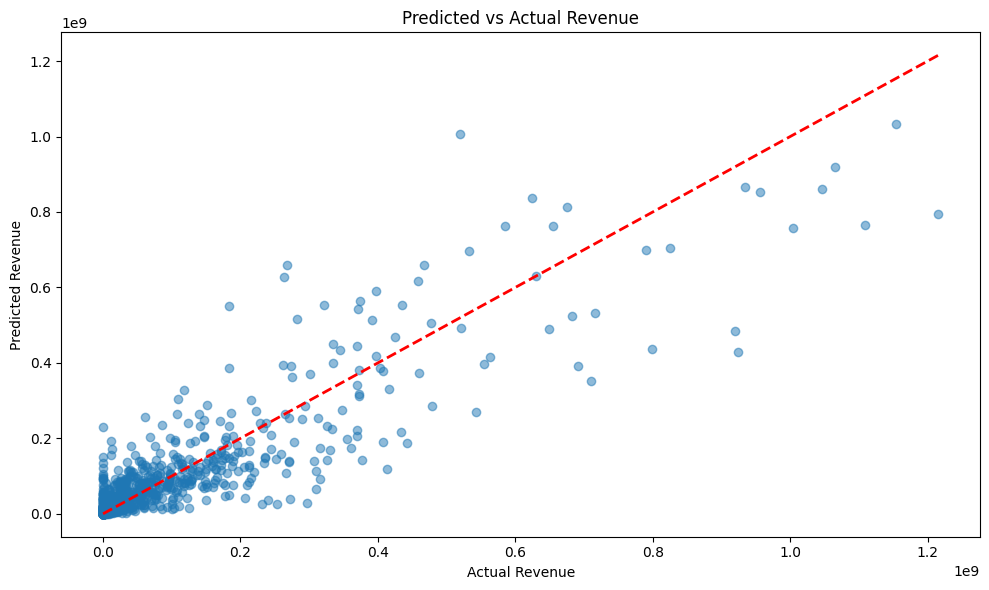

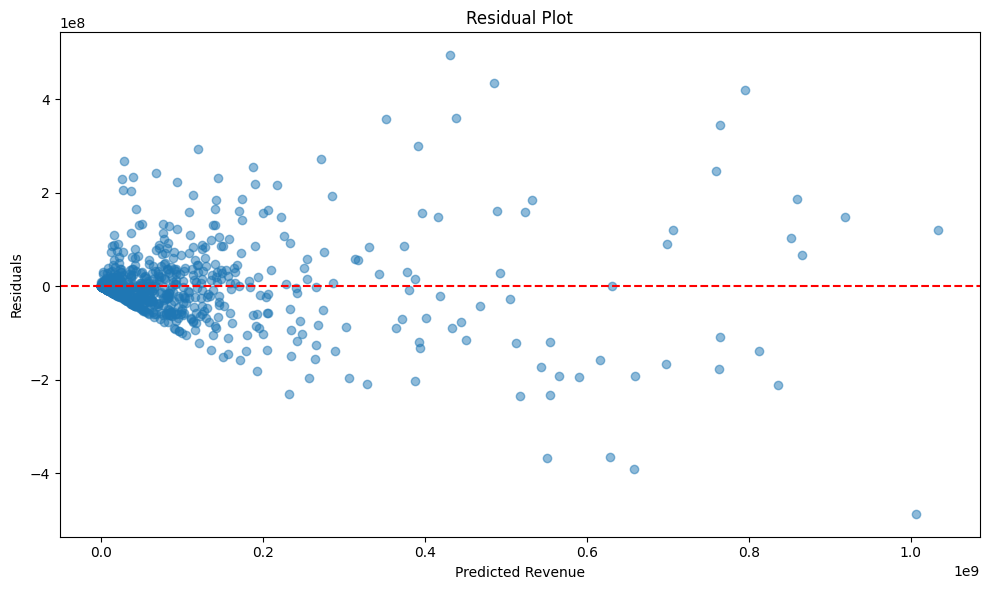

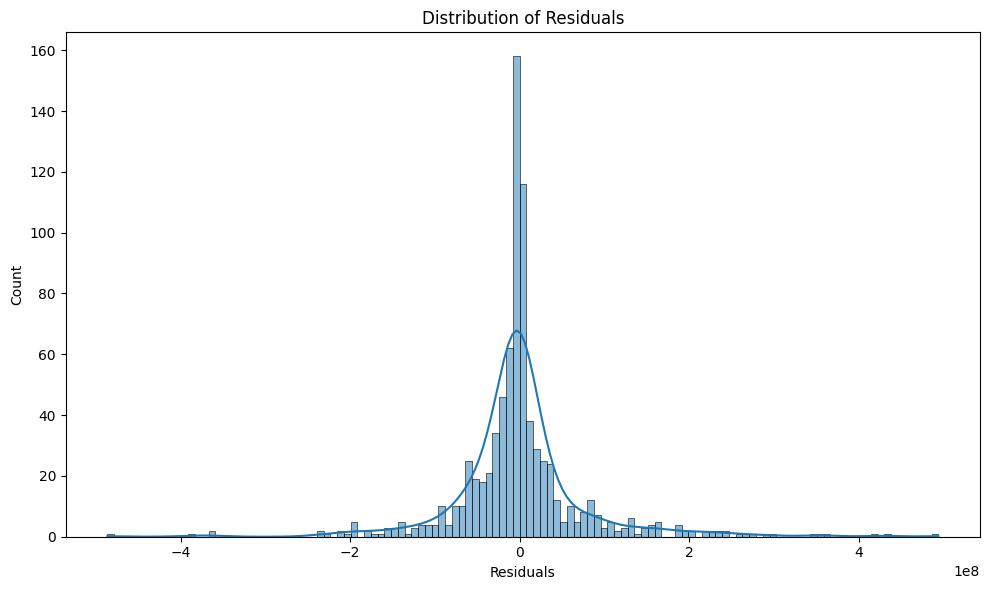

In [18]:
# predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Predicted vs Actual Revenue')
plt.tight_layout()
plt.show()

# residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

Additional analysis

In [19]:
print("\nResiduals Analysis:")
print(f"Mean of residuals: ${residuals.mean():,.2f}")
print(f"Standard deviation of residuals: ${residuals.std():,.2f}")
print(f"Skewness of residuals: {residuals.skew():.2f}")

comparison_df = pd.DataFrame({
    'Actual Revenue': y_test,
    'Predicted Revenue': y_pred,
    'Absolute Error': np.abs(y_test - y_pred),
    'Percentage Error': np.abs((y_test - y_pred) / y_test) * 100
})

print("\nSample Predictions (first 5 movies):")
print(comparison_df.head().to_string())


Residuals Analysis:
Mean of residuals: $418,960.85
Standard deviation of residuals: $79,964,416.26
Skewness of residuals: 0.70

Sample Predictions (first 5 movies):
      Actual Revenue  Predicted Revenue  Absolute Error  Percentage Error
596         33561137       8.246648e+07    4.890534e+07        145.720153
2957               0       9.545268e+05    9.545268e+05               inf
8          933959197       8.660870e+08    6.787221e+07          7.267149
577        171183863       1.702185e+08    9.653273e+05          0.563913
3564        36000000       1.602485e+07    1.997515e+07         55.486536


---


### Thank you for your attention and interest in this analysis!

In [5]:
import pickle

# Try with encoding specified
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/full_transformation_data.pkl', 'rb') as f:
    metadata = pickle.load(f, encoding='latin1')

UnpicklingError: invalid load key, 'v'.